<h1>Scraping Github<h1>

In [2]:
import pandas as pd
from github import Github, GithubException
from datetime import datetime, timedelta
import time

In [296]:
def get_trending_repositories_day(start,token):
    end = datetime.now()
    current = datetime.strptime(start, '%Y-%m-%d')
    g = Github(token)
    repos = []
    limit_counter = 1
    while current <= end:
        try:
            # Search for repositories pushed after the specified date with stars higher than 200
            query = f'pushed:{current.strftime("%Y-%m-%d")} stars:>=200'
            data = g.search_repositories(query=query)
            for repo in data:
                repos.append(repo)
        except GithubException as e:
            if e.status == 403:
                # after each reset limit time get to the next day
                limit_time = (datetime.now()-g.get_rate_limit().core.reset).total_seconds()
                print(f'Rate limit exceeded for the day {current.strftime("%Y-%m-%d")}. Reset time: {limit_time}sec Waiting...')
                time.sleep(limit_time)
                current += timedelta(days=1)
                limit_counter += 1
                continue
    return repos

In [297]:
# getting the start date 
start_date = input('Please enter the starting date (yyyy-mm-dd):')
# calling the function to extract repos using own token
token = input('Please enter your token:')
print(f'Scrapping repos starting from the day {start_date}')
repos = get_trending_repositories_day(start_date,token)

Scrapping repos starting from the day 2023-06-21
Rate limit exceeded for the day 2023-06-21. Reset time: 1.839896sec Waiting...
Rate limit exceeded for the day 2023-06-22. Reset time: 1.293606sec Waiting...


In [298]:
len(repos)

900

In [300]:
columns = ['author','name','full_name','description','link','language','language_list','stars','forks','issues','watchers','pulls_url','commits_url','contributors_url','created_at','updated_at','pushed_at']
df = pd.DataFrame(columns=columns)

g = Github(token)

for rep in repos:
    limit_time = abs((g.get_rate_limit().core.reset-datetime.now()).total_seconds())
    try:
        if g.get_rate_limit().core.remaining == 2500:
            print(f'rate limit exceeded wait {limit_time/2}sec...')
            time.sleep(limit_time/2)
        else:
            df.loc[len(df.index)] = [rep.owner.login,rep.name,rep.full_name,rep.description,rep.html_url,rep.language,list(rep.get_languages().keys()),rep.stargazers_count,rep.forks_count,rep.open_issues,rep.subscribers_count,rep.pulls_url,rep.commits_url,rep.contributors_url,rep.created_at,rep.updated_at,rep.pushed_at]
    except GithubException as e:
            if e.status == 403:
                print(f'rate limit exceeded wait {limit_time}sec...')
                time.sleep(limit_time)
                continue
df

,author,name,full_name,description,link,language,language_list,stars,forks,issues,watchers,pulls_url,commits_url,contributors_url,created_at,updated_at,pushed_at
0,sindresorhus,awesome,sindresorhus/awesome,😎 Awesome lists about all kinds of interesting...,https://github.com/sindresorhus/awesome,None,[],258692,25950,51,7513,https://api.github.com/repos/sindresorhus/awes...,https://api.github.com/repos/sindresorhus/awes...,https://api.github.com/repos/sindresorhus/awes...,2014-07-11 13:42:37,2023-06-22 08:29:43,2023-06-21 20:16:10
1,vuejs,vue,vuejs/vue,"This is the repo for Vue 2. For Vue 3, go to h...",https://github.com/vuejs/vue,TypeScript,"[TypeScript, JavaScript, HTML, CSS, Shell]",204169,33949,639,5992,https://api.github.com/repos/vuejs/vue/pulls{/...,https://api.github.com/repos/vuejs/vue/commits...,https://api.github.com/repos/vuejs/vue/contrib...,2013-07-29 03:24:51,2023-06-22 08:29:29,2023-06-21 11:10:32
2,torvalds,linux,torvalds/linux,Linux kernel source tree,https://github.com/torvalds/linux,C,"[C, Assembly, Shell, Makefile, Python, Perl, R...",153472,48597,312,8177,https://api.github.com/repos/torvalds/linux/pu...,https://api.github.com/repos/torvalds/linux/co...,https://api.github.com/repos/torvalds/linux/co...,2011-09-04 22:48:12,2023-06-22 07:56:03,2023-06-21 19:52:44
3,jlevy,the-art-of-command-line,jlevy/the-art-of-command-line,"Master the command line, in one page",https://github.com/jlevy/the-art-of-command-line,None,[],137133,13629,224,2822,https://api.github.com/repos/jlevy/the-art-of-...,https://api.github.com/repos/jlevy/the-art-of-...,https://api.github.com/repos/jlevy/the-art-of-...,2015-05-20 15:11:03,2023-06-22 08:31:01,2023-06-21 08:51:55
4,Snailclimb,JavaGuide,Snailclimb/JavaGuide,「Java学习+面试指南」一份涵盖大部分 Java 程序员所需要掌握的核心知识。准备 Jav...,https://github.com/Snailclimb/JavaGuide,Java,"[Java, Shell]",134658,44235,65,4547,https://api.github.com/repos/Snailclimb/JavaGu...,https://api.github.com/repos/Snailclimb/JavaGu...,https://api.github.com/repos/Snailclimb/JavaGu...,2018-05-07 13:27:00,2023-06-22 08:33:40,2023-06-21 12:56:44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,PyGithub,PyGithub,PyGithub/PyGithub,Typed interactions with the GitHub API v3,https://github.com/PyGithub/PyGithub,Python,"[Python, Shell]",6077,1641,241,115,https://api.github.com/repos/PyGithub/PyGithub...,https://api.github.com/repos/PyGithub/PyGithub...,https://api.github.com/repos/PyGithub/PyGithub...,2012-02-25 12:53:47,2023-06-21 20:58:22,2023-06-22 06:44:06
896,apache,zeppelin,apache/zeppelin,"Web-based notebook that enables data-driven, i...",https://github.com/apache/zeppelin,Java,"[Java, Jupyter Notebook, JavaScript, TypeScrip...",6075,2757,143,321,https://api.github.com/repos/apache/zeppelin/p...,https://api.github.com/repos/apache/zeppelin/c...,https://api.github.com/repos/apache/zeppelin/c...,2015-03-25 07:00:06,2023-06-21 16:18:28,2023-06-21 07:31:49
897,just-the-docs,just-the-docs,just-the-docs/just-the-docs,"A modern, high customizable, responsive Jekyll...",https://github.com/just-the-docs/just-the-docs,SCSS,"[SCSS, HTML, JavaScript, Ruby, Liquid, Dockerf...",6072,3434,63,58,https://api.github.com/repos/just-the-docs/jus...,https://api.github.com/repos/just-the-docs/jus...,https://api.github.com/repos/just-the-docs/jus...,2017-11-08 16:22:28,2023-06-22 05:23:35,2023-06-21 21:51:04
898,oracle,docker-images,oracle/docker-images,"Official source of container configurations, i...",https://github.com/oracle/docker-images,Shell,"[Shell, Python, Dockerfile, PLSQL, Groovy, Jav...",6070,5356,108,392,https://api.github.com/repos/oracle/docker-ima...,https://api.github.com/repos/oracle/docker-ima...,https://api.github.com/repos/oracle/docker-ima...,2014-12-19 18:53:18,2023-06-21 20:23:42,2023-06-21 22:07:52


In [290]:
# g = Github(token)
# rl = g.get_rate_limit()
# rl_core = rl.core
# rl_search = rl.search
# print(rl_core,rl_search)

In [301]:
df['language'].value_counts().head(10)

Python        139
TypeScript    117
JavaScript    111
Go            108
C++            67
Java           66
C              46
Rust           33
PHP            28
C#             25
Name: language, dtype: int64

In [304]:
df[df['language'].notna()].sort_values(by='stars',ascending=False).head()

,author,name,full_name,description,link,language,language_list,stars,forks,issues,watchers,pulls_url,commits_url,contributors_url,created_at,updated_at,pushed_at
1,vuejs,vue,vuejs/vue,"This is the repo for Vue 2. For Vue 3, go to h...",https://github.com/vuejs/vue,TypeScript,"[TypeScript, JavaScript, HTML, CSS, Shell]",204169,33949,639,5992,https://api.github.com/repos/vuejs/vue/pulls{/...,https://api.github.com/repos/vuejs/vue/commits...,https://api.github.com/repos/vuejs/vue/contrib...,2013-07-29 03:24:51,2023-06-22 08:29:29,2023-06-21 11:10:32
2,torvalds,linux,torvalds/linux,Linux kernel source tree,https://github.com/torvalds/linux,C,"[C, Assembly, Shell, Makefile, Python, Perl, R...",153472,48597,312,8177,https://api.github.com/repos/torvalds/linux/pu...,https://api.github.com/repos/torvalds/linux/co...,https://api.github.com/repos/torvalds/linux/co...,2011-09-04 22:48:12,2023-06-22 07:56:03,2023-06-21 19:52:44
4,Snailclimb,JavaGuide,Snailclimb/JavaGuide,「Java学习+面试指南」一份涵盖大部分 Java 程序员所需要掌握的核心知识。准备 Jav...,https://github.com/Snailclimb/JavaGuide,Java,"[Java, Shell]",134658,44235,65,4547,https://api.github.com/repos/Snailclimb/JavaGu...,https://api.github.com/repos/Snailclimb/JavaGu...,https://api.github.com/repos/Snailclimb/JavaGu...,2018-05-07 13:27:00,2023-06-22 08:33:40,2023-06-21 12:56:44
5,ytdl-org,youtube-dl,ytdl-org/youtube-dl,Command-line program to download videos from Y...,https://github.com/ytdl-org/youtube-dl,Python,"[Python, Shell, Makefile, ActionScript, Batchf...",121251,9068,4737,2203,https://api.github.com/repos/ytdl-org/youtube-...,https://api.github.com/repos/ytdl-org/youtube-...,https://api.github.com/repos/ytdl-org/youtube-...,2010-10-31 14:35:07,2023-06-22 08:36:21,2023-06-21 20:16:45
6,30-seconds,30-seconds-of-code,30-seconds/30-seconds-of-code,Short code snippets for all your development n...,https://github.com/30-seconds/30-seconds-of-code,JavaScript,[JavaScript],113432,11661,3,2620,https://api.github.com/repos/30-seconds/30-sec...,https://api.github.com/repos/30-seconds/30-sec...,https://api.github.com/repos/30-seconds/30-sec...,2017-11-29 17:35:03,2023-06-22 08:33:16,2023-06-21 03:46:12


In [273]:
df.to_csv(f'repos{datetime.now().strftime("%Y%m%d%H%M%S")}.csv',index=False)

<h1>Nettoyage<h1>

In [2]:
df06 = pd.read_csv("repos20230621210440.csv")
df06

,author,name,full_name,description,link,language,language_list,stars,forks,issues,watchers,pulls_url,commits_url,contributors_url,created_at,updated_at,pushed_at
0,ryanmcdermott,clean-code-javascript,ryanmcdermott/clean-code-javascript,:bathtub: Clean Code concepts adapted for Java...,https://github.com/ryanmcdermott/clean-code-ja...,JavaScript,['JavaScript'],83059,11264,86,1857,https://api.github.com/repos/ryanmcdermott/cle...,https://api.github.com/repos/ryanmcdermott/cle...,https://api.github.com/repos/ryanmcdermott/cle...,2016-11-25 22:25:41,2023-06-20 07:27:39,2023-06-01 18:48:51
1,soimort,you-get,soimort/you-get,:arrow_double_down: Dumb downloader that scrap...,https://github.com/soimort/you-get,Python,"['Python', 'Shell', 'Makefile']",47590,9260,385,1368,https://api.github.com/repos/soimort/you-get/p...,https://api.github.com/repos/soimort/you-get/c...,https://api.github.com/repos/soimort/you-get/c...,2012-08-20 15:53:36,2023-06-20 08:28:52,2023-06-01 12:28:25
2,ziishaned,learn-regex,ziishaned/learn-regex,Learn regex the easy way,https://github.com/ziishaned/learn-regex,NaN,[],44212,6260,67,904,https://api.github.com/repos/ziishaned/learn-r...,https://api.github.com/repos/ziishaned/learn-r...,https://api.github.com/repos/ziishaned/learn-r...,2017-07-22 12:21:03,2023-06-20 04:11:28,2023-06-01 13:29:18
3,google,styleguide,google/styleguide,Style guides for Google-originated open-source...,https://github.com/google/styleguide,HTML,"['HTML', 'Python', 'XSLT', 'CSS', 'JavaScript'...",34877,13312,318,1311,https://api.github.com/repos/google/styleguide...,https://api.github.com/repos/google/styleguide...,https://api.github.com/repos/google/styleguide...,2015-05-20 19:18:59,2023-06-20 08:21:02,2023-06-01 09:30:31
4,square,leakcanary,square/leakcanary,A memory leak detection library for Android.,https://github.com/square/leakcanary,Kotlin,"['Kotlin', 'Java', 'Shell', 'AIDL']",28517,3945,72,989,https://api.github.com/repos/square/leakcanary...,https://api.github.com/repos/square/leakcanary...,https://api.github.com/repos/square/leakcanary...,2015-04-29 23:54:16,2023-06-19 17:34:09,2023-06-01 16:28:09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8850,ipyflow,ipyflow,ipyflow/ipyflow,A reactive Python kernel for Jupyter notebooks.,https://github.com/ipyflow/ipyflow,Python,"['Python', 'TypeScript', 'Shell', 'CSS', 'Java...",919,17,19,6,https://api.github.com/repos/ipyflow/ipyflow/p...,https://api.github.com/repos/ipyflow/ipyflow/c...,https://api.github.com/repos/ipyflow/ipyflow/c...,2020-01-14 18:02:25,2023-06-20 06:31:25,2023-06-12 02:42:26
8851,AccumulateMore,CV,AccumulateMore/CV,✔️最全面的 深度学习 笔记【我是土堆 Pytorch】【李沐 动手学深度学习】【吴恩达 深...,https://github.com/AccumulateMore/CV,Jupyter Notebook,['Jupyter Notebook'],921,185,2,5,https://api.github.com/repos/AccumulateMore/CV...,https://api.github.com/repos/AccumulateMore/CV...,https://api.github.com/repos/AccumulateMore/CV...,2022-03-31 13:19:32,2023-06-20 11:43:27,2023-06-20 01:42:49
8852,jamulussoftware,jamulus,jamulussoftware/jamulus,Jamulus enables musicians to perform real-time...,https://github.com/jamulussoftware/jamulus,C,"['C', 'C++', 'Shell', 'Makefile', 'NSIS', 'M4'...",919,216,116,32,https://api.github.com/repos/jamulussoftware/j...,https://api.github.com/repos/jamulussoftware/j...,https://api.github.com/repos/jamulussoftware/j...,2019-03-23 12:44:25,2023-06-09 19:01:28,2023-06-17 06:52:23
8853,fo-dicom,fo-dicom,fo-dicom/fo-dicom,"Fellow Oak DICOM for .NET, .NET Core, Universa...",https://github.com/fo-dicom/fo-dicom,C#,"['C#', 'Batchfile']",919,606,118,106,https://api.github.com/repos/fo-dicom/fo-dicom...,https://api.github.com/repos/fo-dicom/fo-dicom...,https://api.github.com/repos/fo-dicom/fo-dicom...,2015-05-09 13:35:00,2023-06-20 00:44:59,2023-06-12 14:09:38


Duplicated Values

In [4]:
df06.duplicated(subset=['author','full_name','pushed_at']).sum()

338

In [5]:
# df06[df06.duplicated(subset=['author','full_name','pushed_at'])].count()

In [6]:
# df06.drop_duplicates(subset=['author','full_name','pushed_at'],inplace=True)

In [7]:
# df06[df06.duplicated(subset=['author','full_name','pushed_at'])].count()

Missing values

In [16]:
df06.isna().sum()

author              0
name                0
full_name           0
description         0
link                0
language            0
language_list       0
stars               0
forks               0
issues              0
watchers            0
pulls_url           0
commits_url         0
contributors_url    0
created_at          0
updated_at          0
pushed_at           0
dtype: int64

In [17]:
df06[df06['language'].isna()]

,author,name,full_name,description,link,language,language_list,stars,forks,issues,watchers,pulls_url,commits_url,contributors_url,created_at,updated_at,pushed_at


In [18]:
df06['language'].fillna('non-code',inplace=True)

In [19]:
df06.isna().sum()

author              0
name                0
full_name           0
description         0
link                0
language            0
language_list       0
stars               0
forks               0
issues              0
watchers            0
pulls_url           0
commits_url         0
contributors_url    0
created_at          0
updated_at          0
pushed_at           0
dtype: int64

In [20]:
df06[df06['description'].isna()]

,author,name,full_name,description,link,language,language_list,stars,forks,issues,watchers,pulls_url,commits_url,contributors_url,created_at,updated_at,pushed_at


In [21]:
df06['description'].fillna('No description',inplace=True)

In [22]:
df06.isna().sum()

author              0
name                0
full_name           0
description         0
link                0
language            0
language_list       0
stars               0
forks               0
issues              0
watchers            0
pulls_url           0
commits_url         0
contributors_url    0
created_at          0
updated_at          0
pushed_at           0
dtype: int64

In [51]:
df06[df06['description'].str.len() < 10]['description'].count()

36

In [52]:
# Create a Boolean mask for rows with a 'description' length less than 10
mask = df06['description'].str.len() < 10

# Drop the rows that have 'True' in the mask
df06 = df06[~mask]
df06[df06['description'].str.len() < 10]['description'].count()

0

In [67]:
import pandas as pd
from langdetect import detect, LangDetectException
import mtranslate

# Define a function to detect the language of a sentence using the langdetect package
def detect_language(sentence):
    try:
        lang = detect(sentence)
    except:
        lang = 'unknown'
    # print(lang)
    return lang

# Define a function to translate a sentence using the googletrans package
def translate_sentence(sentence, target_lang):
    try:
        translated_sentence = mtranslate.translate(sentence, to_language=target_lang)
    except:
        return sentence
    return translated_sentence

# Iterate over each row of the DataFrame
for index, row in df06.iterrows():
    try:
        # Detect the language of the description
        # lang = detect_language(row['description'])
        
        # Translate the description if it's not in English
        if lang != 'en':
            df06.at[index, 'description_translated'] = translate_sentence(row['description'], 'en')
        else:
            df06.at[index, 'description_translated'] = row['description']
    except LangDetectException as e:
        print(f"Error {e} at description: {row['full_name']} {row['description']}")
        df06.at[index, 'description_translated'] = row['description']
        continue

In [68]:
df06

,author,name,full_name,description,link,language,language_list,stars,forks,issues,watchers,pulls_url,commits_url,contributors_url,created_at,updated_at,pushed_at,description_translated
0,ryanmcdermott,clean-code-javascript,ryanmcdermott/clean-code-javascript,:bathtub: Clean Code concepts adapted for Java...,https://github.com/ryanmcdermott/clean-code-ja...,JavaScript,['JavaScript'],83059,11264,86,1857,https://api.github.com/repos/ryanmcdermott/cle...,https://api.github.com/repos/ryanmcdermott/cle...,https://api.github.com/repos/ryanmcdermott/cle...,2016-11-25 22:25:41,2023-06-20 07:27:39,2023-06-01 18:48:51,:bathtub: Clean Code concepts adapted for Java...
1,soimort,you-get,soimort/you-get,:arrow_double_down: Dumb downloader that scrap...,https://github.com/soimort/you-get,Python,"['Python', 'Shell', 'Makefile']",47590,9260,385,1368,https://api.github.com/repos/soimort/you-get/p...,https://api.github.com/repos/soimort/you-get/c...,https://api.github.com/repos/soimort/you-get/c...,2012-08-20 15:53:36,2023-06-20 08:28:52,2023-06-01 12:28:25,:arrow_double_down: Dumb downloader that scrap...
2,ziishaned,learn-regex,ziishaned/learn-regex,Learn regex the easy way,https://github.com/ziishaned/learn-regex,non-code,[],44212,6260,67,904,https://api.github.com/repos/ziishaned/learn-r...,https://api.github.com/repos/ziishaned/learn-r...,https://api.github.com/repos/ziishaned/learn-r...,2017-07-22 12:21:03,2023-06-20 04:11:28,2023-06-01 13:29:18,Learn regex the easy way
3,google,styleguide,google/styleguide,Style guides for Google-originated open-source...,https://github.com/google/styleguide,HTML,"['HTML', 'Python', 'XSLT', 'CSS', 'JavaScript'...",34877,13312,318,1311,https://api.github.com/repos/google/styleguide...,https://api.github.com/repos/google/styleguide...,https://api.github.com/repos/google/styleguide...,2015-05-20 19:18:59,2023-06-20 08:21:02,2023-06-01 09:30:31,Style guides for Google-originated open-source...
4,square,leakcanary,square/leakcanary,A memory leak detection library for Android.,https://github.com/square/leakcanary,Kotlin,"['Kotlin', 'Java', 'Shell', 'AIDL']",28517,3945,72,989,https://api.github.com/repos/square/leakcanary...,https://api.github.com/repos/square/leakcanary...,https://api.github.com/repos/square/leakcanary...,2015-04-29 23:54:16,2023-06-19 17:34:09,2023-06-01 16:28:09,A memory leak detection library for Android.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8850,ipyflow,ipyflow,ipyflow/ipyflow,A reactive Python kernel for Jupyter notebooks.,https://github.com/ipyflow/ipyflow,Python,"['Python', 'TypeScript', 'Shell', 'CSS', 'Java...",919,17,19,6,https://api.github.com/repos/ipyflow/ipyflow/p...,https://api.github.com/repos/ipyflow/ipyflow/c...,https://api.github.com/repos/ipyflow/ipyflow/c...,2020-01-14 18:02:25,2023-06-20 06:31:25,2023-06-12 02:42:26,A reactive Python kernel for Jupyter notebooks.
8851,AccumulateMore,CV,AccumulateMore/CV,✔️最全面的 深度学习 笔记【我是土堆 Pytorch】【李沐 动手学深度学习】【吴恩达 深...,https://github.com/AccumulateMore/CV,Jupyter Notebook,['Jupyter Notebook'],921,185,2,5,https://api.github.com/repos/AccumulateMore/CV...,https://api.github.com/repos/AccumulateMore/CV...,https://api.github.com/repos/AccumulateMore/CV...,2022-03-31 13:19:32,2023-06-20 11:43:27,2023-06-20 01:42:49,✔️The most comprehensive deep learning notes [...
8852,jamulussoftware,jamulus,jamulussoftware/jamulus,Jamulus enables musicians to perform real-time...,https://github.com/jamulussoftware/jamulus,C,"['C', 'C++', 'Shell', 'Makefile', 'NSIS', 'M4'...",919,216,116,32,https://api.github.com/repos/jamulussoftware/j...,https://api.github.com/repos/jamulussoftware/j...,https://api.github.com/repos/jamulussoftware/j...,2019-03-23 12:44:25,2023-06-09 19:01:28,2023-06-17 06:52:23,Jamulus enables musicians to perform real-time...
8853,fo-dicom,fo-dicom,fo-dicom/fo-dicom,"Fellow Oak DICOM for .NET, .NET Core, Universa...",https://github.com/fo-dicom/fo-dicom,C#,"['C#', 'Batchfile']",919,606,118,106,https://

In [69]:
# Save the translated DataFrame to a file
df06.to_csv(f'repos_description_translated{datetime.now().strftime("%Y%m%d%H%M%S")}.csv', index=False)

In [70]:
import re

# Define a regular expression pattern to match emojis and special characters
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"  # other special characters
        u"\U000024C2-\U0001F251" 
                           "]+", flags=re.UNICODE)

# Remove emojis and special characters from the 'text' column
df06['description_translated'] = df06['description_translated'].apply(lambda x: emoji_pattern.sub(r'', x))
df06

C:\Users\Youcode\AppData\Local\Temp\ipykernel_56560\4310486.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df06['description_translated'] = df06['description_translated'].apply(lambda x: emoji_pattern.sub(r'', x))


,author,name,full_name,description,link,language,language_list,stars,forks,issues,watchers,pulls_url,commits_url,contributors_url,created_at,updated_at,pushed_at,description_translated
0,ryanmcdermott,clean-code-javascript,ryanmcdermott/clean-code-javascript,:bathtub: Clean Code concepts adapted for Java...,https://github.com/ryanmcdermott/clean-code-ja...,JavaScript,['JavaScript'],83059,11264,86,1857,https://api.github.com/repos/ryanmcdermott/cle...,https://api.github.com/repos/ryanmcdermott/cle...,https://api.github.com/repos/ryanmcdermott/cle...,2016-11-25 22:25:41,2023-06-20 07:27:39,2023-06-01 18:48:51,:bathtub: Clean Code concepts adapted for Java...
1,soimort,you-get,soimort/you-get,:arrow_double_down: Dumb downloader that scrap...,https://github.com/soimort/you-get,Python,"['Python', 'Shell', 'Makefile']",47590,9260,385,1368,https://api.github.com/repos/soimort/you-get/p...,https://api.github.com/repos/soimort/you-get/c...,https://api.github.com/repos/soimort/you-get/c...,2012-08-20 15:53:36,2023-06-20 08:28:52,2023-06-01 12:28:25,:arrow_double_down: Dumb downloader that scrap...
2,ziishaned,learn-regex,ziishaned/learn-regex,Learn regex the easy way,https://github.com/ziishaned/learn-regex,non-code,[],44212,6260,67,904,https://api.github.com/repos/ziishaned/learn-r...,https://api.github.com/repos/ziishaned/learn-r...,https://api.github.com/repos/ziishaned/learn-r...,2017-07-22 12:21:03,2023-06-20 04:11:28,2023-06-01 13:29:18,Learn regex the easy way
3,google,styleguide,google/styleguide,Style guides for Google-originated open-source...,https://github.com/google/styleguide,HTML,"['HTML', 'Python', 'XSLT', 'CSS', 'JavaScript'...",34877,13312,318,1311,https://api.github.com/repos/google/styleguide...,https://api.github.com/repos/google/styleguide...,https://api.github.com/repos/google/styleguide...,2015-05-20 19:18:59,2023-06-20 08:21:02,2023-06-01 09:30:31,Style guides for Google-originated open-source...
4,square,leakcanary,square/leakcanary,A memory leak detection library for Android.,https://github.com/square/leakcanary,Kotlin,"['Kotlin', 'Java', 'Shell', 'AIDL']",28517,3945,72,989,https://api.github.com/repos/square/leakcanary...,https://api.github.com/repos/square/leakcanary...,https://api.github.com/repos/square/leakcanary...,2015-04-29 23:54:16,2023-06-19 17:34:09,2023-06-01 16:28:09,A memory leak detection library for Android.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8850,ipyflow,ipyflow,ipyflow/ipyflow,A reactive Python kernel for Jupyter notebooks.,https://github.com/ipyflow/ipyflow,Python,"['Python', 'TypeScript', 'Shell', 'CSS', 'Java...",919,17,19,6,https://api.github.com/repos/ipyflow/ipyflow/p...,https://api.github.com/repos/ipyflow/ipyflow/c...,https://api.github.com/repos/ipyflow/ipyflow/c...,2020-01-14 18:02:25,2023-06-20 06:31:25,2023-06-12 02:42:26,A reactive Python kernel for Jupyter notebooks.
8851,AccumulateMore,CV,AccumulateMore/CV,✔️最全面的 深度学习 笔记【我是土堆 Pytorch】【李沐 动手学深度学习】【吴恩达 深...,https://github.com/AccumulateMore/CV,Jupyter Notebook,['Jupyter Notebook'],921,185,2,5,https://api.github.com/repos/AccumulateMore/CV...,https://api.github.com/repos/AccumulateMore/CV...,https://api.github.com/repos/AccumulateMore/CV...,2022-03-31 13:19:32,2023-06-20 11:43:27,2023-06-20 01:42:49,The most comprehensive deep learning notes [I ...
8852,jamulussoftware,jamulus,jamulussoftware/jamulus,Jamulus enables musicians to perform real-time...,https://github.com/jamulussoftware/jamulus,C,"['C', 'C++', 'Shell', 'Makefile', 'NSIS', 'M4'...",919,216,116,32,https://api.github.com/repos/jamulussoftware/j...,https://api.github.com/repos/jamulussoftware/j...,https://api.github.com/repos/jamulussoftware/j...,2019-03-23 12:44:25,2023-06-09 19:01:28,2023-06-17 06:52:23,Jamulus enables musicians to perform real-time...
8853,fo-dicom,fo-dicom,fo-dicom/fo-dicom,"Fellow Oak DICOM for .NET, .NET Core, Universa...",https://github.com/fo-dicom/fo-dicom,C#,"['C#', 'Batchfile']",919,606,118,106,https://

In [73]:
# Check if the 'text' column contains any emojis or special characters
has_emoji_or_special_char = df06['description_translated'].str.contains(emoji_pattern).any()

if has_emoji_or_special_char:
    print("The 'description_translated' column contains emojis or special characters.")
else:
    print("The 'description_translated' column does not contain any emojis or special characters.")

The 'description_translated' column does not contain any emojis or special characters.


In [94]:
df06[(df06['description_translated'] == 'No description') & (df06['language'] == 'non-code')].count()

author                    31
name                      31
full_name                 31
description               31
link                      31
language                  31
language_list             31
stars                     31
forks                     31
issues                    31
watchers                  31
pulls_url                 31
commits_url               31
contributors_url          31
created_at                31
updated_at                31
pushed_at                 31
description_translated    31
dtype: int64

In [97]:
mask = (df06['description_translated'] == 'No description') & (df06['language'] == 'non-code')
df06 = df06[~mask]
df06[(df06['description_translated'] == 'No description') & (df06['language'] == 'non-code')].count()

author                    0
name                      0
full_name                 0
description               0
link                      0
language                  0
language_list             0
stars                     0
forks                     0
issues                    0
watchers                  0
pulls_url                 0
commits_url               0
contributors_url          0
created_at                0
updated_at                0
pushed_at                 0
description_translated    0
dtype: int64

In [99]:
df06.shape

(8788, 18)

Outliers Values

<Axes: >

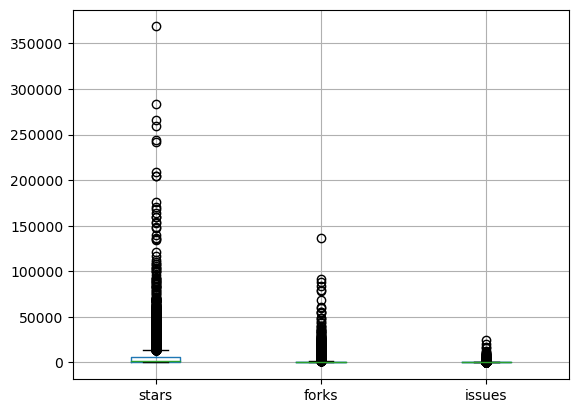

In [ ]:
df06.boxplot()